In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torch.version.cuda)
print(torchaudio.__version__)

2.2.2+cu121
12.1
2.2.2+cu121


In [3]:
import torch

def list_gpus():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"Total number of available GPU(s): {num_gpus}\n")
        
        for i in range(num_gpus):
            print(f"GPU {i}:")
            print(f"  Name: {torch.cuda.get_device_name(i)}")
            print(f"  Capability: {torch.cuda.get_device_capability(i)}")
            print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
            print(f"  Multiprocessors: {torch.cuda.get_device_properties(i).multi_processor_count}")
            # print(f"  Maximum Threads per Block: {torch.cuda.get_device_properties(i).max_threads_per_block}")
            print("-" * 40)
    else:
        print("No CUDA-enabled GPU is available.")

# Call the function to list GPUs
list_gpus()

Total number of available GPU(s): 8

GPU 0:
  Name: NVIDIA RTX A6000
  Capability: (8, 6)
  Total Memory: 51.04 GB
  Multiprocessors: 84
----------------------------------------
GPU 1:
  Name: NVIDIA RTX A6000
  Capability: (8, 6)
  Total Memory: 51.04 GB
  Multiprocessors: 84
----------------------------------------
GPU 2:
  Name: NVIDIA RTX A6000
  Capability: (8, 6)
  Total Memory: 51.04 GB
  Multiprocessors: 84
----------------------------------------
GPU 3:
  Name: NVIDIA RTX A6000
  Capability: (8, 6)
  Total Memory: 51.04 GB
  Multiprocessors: 84
----------------------------------------
GPU 4:
  Name: NVIDIA RTX A6000
  Capability: (8, 6)
  Total Memory: 51.04 GB
  Multiprocessors: 84
----------------------------------------
GPU 5:
  Name: NVIDIA RTX A6000
  Capability: (8, 6)
  Total Memory: 51.04 GB
  Multiprocessors: 84
----------------------------------------
GPU 6:
  Name: NVIDIA RTX A6000
  Capability: (8, 6)
  Total Memory: 51.04 GB
  Multiprocessors: 84
-----------------

In [4]:
import os
import glob
import pickle

DATA_DIR = "/proj/vondrick/aa4870/lipreading-data/mvlrs_v1"


def get_mp4_files(directory):
    # Use a glob pattern to match all .mp4 files
    pattern = os.path.join(directory, '**', '*.mp4')
    mp4_files = glob.glob(pattern, recursive=True)
    return mp4_files


In [5]:
if not os.path.exists("lrs_video_files.pkl"):
    mp4_files = get_mp4_files(DATA_DIR)
    pickle.dump(mp4_files, open("lrs_video_files.pkl", "wb+"))
else:
    mp4_files = pickle.load(open("lrs_video_files.pkl", "rb"))

In [7]:
import cv2

video_dataset_by_frame = {}

for i, video_path in enumerate(mp4_files):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError("Cannot open video file: {}".format(video_path))

    video_fps = cap.get(cv2.CAP_PROP_FPS)
    if video_fps == 0:
        raise ValueError("FPS is zero, which may indicate an issue with the video file or codec.")

    # Calculate total frames and adjust read rate for fps of 30
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, int(video_fps / 30))
    
    frame_indices = []
    for i in range(0, total_frames - step, step):
        frame_indices.append((i, i + step))
    
    cap.release()

    video_dataset_by_frame[video_path] = frame_indices

    if (i + 1) % 1000 == 0:
        print(f"Processed {i*1000} files.")

KeyboardInterrupt: 

In [4]:
import pickle

from preprocessing.extract_video_frames import *

dataset = pickle.load(open("preprocessing/video_dataset_list.pkl", "rb"))

In [6]:
import sys

sys.getsizeof(dataset) / (1024 ** 2)

169.77320098876953

In [8]:
os.cpu_count()

128

In [29]:
import cv2
import os

test_file = os.path.join(DATA_DIR, "main", "6099843980233334135", "00003.mp4")

cap = cv2.VideoCapture(test_file)
if not cap.isOpened():
    raise IOError("Cannot open video file: {}".format(test_file))

video_fps = cap.get(cv2.CAP_PROP_FPS)
if video_fps == 0:
    raise ValueError("FPS is zero, which may indicate an issue with the video file or codec.")

frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB

# Ensure there are frames to process
if not frames:
    raise ValueError("No frames were read from the video, check the video file and codec.")

step = max(1, int(video_fps // 30))
frames = frames[::step]
cap.release()

In [24]:
import matplotlib.pyplot as plt

plt.imshow(frames[0])

NameError: name 'frames' is not defined

In [31]:
len(frames)

26

In [35]:
from pydub import AudioSegment
from IPython.display import Audio
import io

# Using pydub to extract audio from the video
audio = AudioSegment.from_file(test_file, format="mp4")

# Export audio to an audio format that IPython can play (e.g., WAV)
audio_buffer = io.BytesIO()
audio.export(audio_buffer, format="wav")

# Reset buffer position to the start
audio_buffer.seek(0)

# Use IPython.display.Audio to play the audio
Audio(audio_buffer.read(), autoplay=True, rate=audio.frame_rate)


In [8]:
from dataset import *

train_files, val_files, test_files = split_data(mp4_files)

In [25]:
import torchvision.transforms as transforms

# video_transform = Compose([
#         transforms.ToPILImage(),        # Convert the tensors to PIL images
#         transforms.Resize((128, 128)),  # Resize to a fixed size for uniformity
#         transforms.ToTensor(),          # Convert back to tensor
# ])

video_transform = transforms.Compose([
    transforms.ToPILImage(),        # Convert the tensor to PIL image
    transforms.Resize((128, 128)),  # Resize to 128x128 for uniformity
    transforms.ToTensor(),          # Convert the PIL image back to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

train_dataset = TalkingFaceDataset(train_files, transform=video_transform)
val_dataset = TalkingFaceDataset(val_files, transform=video_transform)
test_dataset = TalkingFaceDataset(test_files, transform=video_transform)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encod

In [16]:
train_dataset[0]

(tensor([[[19., 12., 12.],
          [17., 10., 10.],
          [17., 10., 10.],
          ...,
          [21., 11., 15.],
          [21., 11., 15.],
          [21., 11., 15.]],
 
         [[19., 12., 12.],
          [17., 10., 10.],
          [17., 10., 10.],
          ...,
          [21., 11., 15.],
          [21., 11., 15.],
          [21., 11., 15.]],
 
         [[19., 12., 12.],
          [17., 10., 10.],
          [17., 10., 10.],
          ...,
          [21., 11., 15.],
          [21., 11., 15.],
          [21., 11., 15.]],
 
         ...,
 
         [[29., 19., 20.],
          [29., 19., 20.],
          [29., 19., 20.],
          ...,
          [32., 20., 22.],
          [32., 20., 22.],
          [32., 20., 22.]],
 
         [[29., 19., 20.],
          [29., 19., 20.],
          [29., 19., 20.],
          ...,
          [32., 20., 22.],
          [32., 20., 22.],
          [32., 20., 22.]],
 
         [[29., 19., 20.],
          [29., 19., 20.],
          [29., 19., 20.],
   

In [23]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming train_dataset[50][1] is a list of frames where each frame needs to be reshaped and normalized
# frames = train_dataset[50][1]  # list of frames

def plot_video(frames, interval=50):
    fig, ax = plt.subplots()
    
    def update(frame_index):
        image = frames[frame_index]  # Reshape and normalize
        if image.dtype == torch.float32:  # Check if the image is a float type
            if image.max() > 1.0:  # Assume the range should be [0, 1]
                image = image / 255.0  # Scale down if it was in [0, 255]
                
        image = image.numpy()  # Convert to numpy array if it's a tensor
        if len(image.shape) == 3 and image.shape[0] in [3, 4]:  # CHW format
            image = image.transpose((1, 2, 0)) 

        ax.clear()  # Clear the previous frame
        ax.imshow(image)
        ax.set_axis_off()  # Turn off axes for a nicer view
    
    ani = FuncAnimation(fig, update, frames=len(frames), interval=interval)
    plt.close(fig)  # Prevents an additional empty plot from displaying
    return ani

# Create animation and display it in the notebook
animation = plot_video(train_dataset[0][1])
HTML(animation.to_jshtml())  # Use JavaScript HTML for playing animation


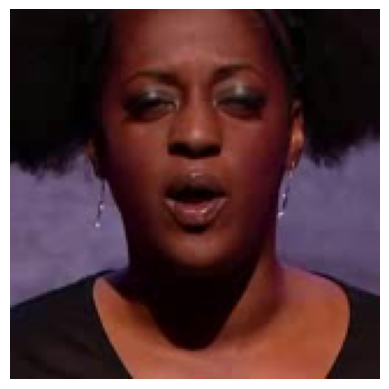

In [22]:
def display_image(image):
    if image.dtype == torch.float32:  # Check if the image is a float type
        if image.max() > 1.0:  # Assume the range should be [0, 1]
            image = image / 255.0  # Scale down if it was in [0, 255]
    image = image.numpy()  # Convert to numpy array if it's a tensor
    if len(image.shape) == 3 and image.shape[0] in [3, 4]:  # CHW format
        image = image.transpose((1, 2, 0))  # Convert to HWC format for matplotlib

    plt.imshow(image)
    plt.axis('off')
    plt.show()

display_image(train_dataset[0][0])

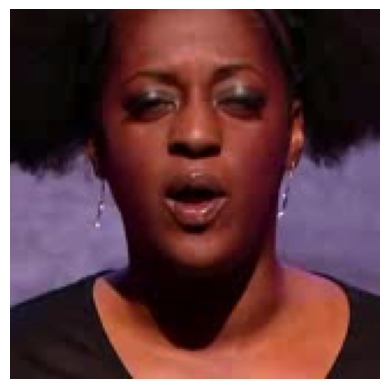

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def display_image(image):
    # Ensure image is a numpy array
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()  # Ensure it's on CPU and convert to numpy

    # Handle different data formats
    if len(image.shape) == 3 and image.shape[0] in [3, 4]:  # CHW format
        image = image.transpose((1, 2, 0))  # Convert CHW to HWC

    # Detect and adjust range if necessary
    if image.dtype == np.float32:
        # Check for image range and normalize to [0, 1]
        min_val = image.min()
        max_val = image.max()
        
        # Normalize based on detected range
        if min_val >= -1.0 and max_val <= 1.0:
            # Image normalized to [-1, 1]
            image = (image + 1.0) / 2.0  # Scale to [0, 1]
        elif min_val < 0 or max_val > 1:
            # Image possibly zero-centered around [-0.5, 0.5] or other ranges
            image = image - min_val  # Shift to [0, max_val-min_val]
            image = image / (max_val - min_val)  # Normalize to [0, 1]

    # Ensure all values are within [0, 1] by clipping
    image = np.clip(image, 0, 1)

    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

display_image(train_dataset[0][0])